In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import load_everything
#from validation import plot_confusion_mat


## Load the Dataset

In [2]:
# the dataset contains all of the metadata test and train sets are self explanatory 
# no shuffling is required this is all done in the loader. indexes match between the dataset and x_train etc
# to index for the test set do dataset[len(x_train):]
dataset, (x_train, x_test, y_train, y_test) = load_everything(os.path.join('..', 'datasets'))

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6708 entries, 0 to 6707
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   img_name        6708 non-null   string  
 1   img_source      6708 non-null   category
 2   fire            6708 non-null   bool    
 3   pos_y           1000 non-null   float64 
 4   pos_x           1000 non-null   float64 
 5   wind_direction  1000 non-null   float64 
 6   wind_strength   1000 non-null   float64 
dtypes: bool(1), category(1), float64(4), string(1)
memory usage: 327.7 KB


In [4]:
dataset.head()

,img_name,img_source,fire,pos_y,pos_x,wind_direction,wind_strength
0,1188-176225_sat_51,DeepGlobe,True,100.0,174.0,4.259894,0.238864
1,5712-242583_sat_10,DeepGlobe,False,NaN,NaN,NaN,NaN
2,0247-784518_sat_67,DeepGlobe,True,99.0,74.0,6.264771,0.090120
3,5777-208695_sat_71,DeepGlobe,False,NaN,NaN,NaN,NaN
4,2836-255876_sat_31,DeepGlobe,False,NaN,NaN,NaN,NaN


In [5]:
# check if it's within [0, 1] range
print(f'x_train: max({x_train.max()}), min({x_train.min()})\nx_test:  max({x_test.max()}), min({x_test.min()})')

x_train: max(1.0), min(0.0)
x_test:  max(1.0), min(0.0)


In [6]:
print(x_train.shape)

(5031, 256, 256, 3)


In [7]:
label_stats = pd.concat([
        dataset['fire'].value_counts(),
        dataset['fire'].value_counts(normalize=True)
    ],
    keys=['counts', 'normalized_counts'],
    axis=1,
)
print(label_stats)

       counts  normalized_counts
False    5708           0.850924
True     1000           0.149076


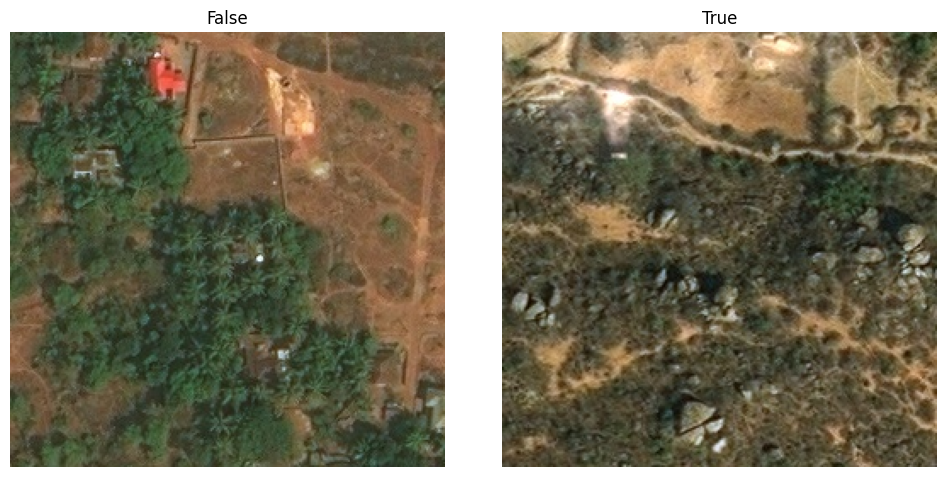

In [8]:
def show_image_samples(dataset):
    labels = np.unique(dataset['fire'])
    fig, axs = plt.subplots(1, len(labels))
    fig.set_size_inches(10,5)
    fig.tight_layout()

    for ax, label in zip(axs, labels):
        img_sample = dataset[dataset['fire'] == label].sample(1)
        img_name = f'{img_sample["img_name"].iloc[0]}.jpg'
        img_path = os.path.join(dataset_base_path, img_name)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

dataset_base_path = os.path.join('../datasets', 'generated')
show_image_samples(dataset)

## Fitting a model to our dataset

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2 
from tensorflow.keras import models

from tensorflow.keras.layers.experimental import preprocessing
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [10]:
def get_input_shape(data):
    _, *input_shape = data.shape
    return input_shape

def reshape_data(data, base_size):
    reshaped = [cv2.resize(img, base_size) for img in data]
    return np.array(reshaped)

def standardise(*data):
    data = [d / 255.0 for d in data]
    return data

def add_seq_layers(layers):
    model = models.Sequential([
        *layers
    ])
    return model
            
def plot_model_history(history):
    plt.figure(1, figsize = (15,8)) 
    plt.subplot(221)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 

    plt.subplot(222)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 

    plt.show()

In [11]:
# VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop

In [12]:
base_size = (50, 50)

x_train_reshaped, x_test_reshaped = list(map(lambda x: reshape_data(x, base_size), [x_train, x_test]))
print(f'x_train_reshaped: {x_train_reshaped.shape}')

x_train_reshaped: (5031, 50, 50, 3)


In [13]:
# input_shape = get_input_shape(x_train_reshaped)

# vgg16_base_model = VGG16(
#     include_top = False, 
#     weights = 'imagenet', 
#     input_shape = input_shape
# )

# for layer in vgg16_base_model.layers:
#     layer.trainable = False
    
# outputs = Flatten()(vgg16_base_model.output)

# outputs = Dense(1024, activation='relu')(outputs)
# outputs = Dropout(0.5)(outputs)

# outputs = BatchNormalization()(outputs)

# outputs = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(outputs)
# outputs = Dropout(0.5)(outputs)

# outputs = Dense(1, activation='sigmoid')(outputs)

# vgg16_model = Model(vgg16_base_model.input, outputs)
# vgg16_model.compile(
#     optimizer = Adam(learning_rate = 0.00001),
#     loss = 'binary_crossentropy',
#     metrics = ['acc']
# )

# vgg16_model_history = vgg16_model.fit(
#     x_train_reshaped, 
#     y_train, 
#     validation_data = (x_test_reshaped, y_test), 
#     epochs = 50,
#     steps_per_epoch = 100
# )

In [14]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report

# #Plot the Accuracy and Loss Curves
# plot_model_history(vgg16_model_history)

# # Plot the confusion matrix
# from sklearn.metrics import confusion_matrix

# y_pred = vgg16_model.predict(x_test_reshaped)
# y_pred = np.round(y_pred)

# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print(classification_report(y_test, y_pred))

# sns.heatmap(cm, annot=True, fmt='d')



In [15]:
# Inception
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_size = (224, 224)
x_train_reshaped, x_test_reshaped = list(map(lambda x: reshape_data(x, base_size), [x_train, x_test]))
print(f'x_train_reshaped: {x_train_reshaped.shape}')

In [ ]:
input_shape = get_input_shape(x_train_reshaped)
inception_base_model = InceptionV3(
    include_top = False,
    input_shape = input_shape, 
    weights = 'imagenet'
)

for layer in inception_base_model.layers:
    layer.trainable = False


# custom_layers = [
#   preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
# #   preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
# ]

# data_augmentation = add_seq_layers(custom_layers)

# inputs = Input(shape=input_shape)
# outputs = preprocessing.Rescaling(1./255)(inputs)
# augmented_input = data_augmentation(inputs)

# inception = inception_base_model(outputs)
outputs = GlobalAveragePooling2D(name='avg_pool')(inception_base_model.output)
# outputs = Flatten()(inception_base_model.output)
outputs = Dense(1024, activation='relu')(outputs)
outputs = Dropout(0.5)(outputs)

outputs = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(outputs)
outputs = Dropout(0.5)(outputs)

outputs = Dense(256, activation='relu')(outputs)
outputs = Dropout(0.5)(outputs)

outputs = Dense(1, activation='sigmoid')(outputs)

inception_model = Model(inception_base_model.input, outputs)
inception_model.summary()
inception_model.compile(
    optimizer = Adam(learning_rate = 0.00001), 
    loss = 'binary_crossentropy', 
    metrics = ['acc']
)
inception_model_history = inception_model.fit(
    x_train_reshaped, 
    y_train, 
    validation_data = (x_test_reshaped, y_test), 
    epochs = 60,
    steps_per_epoch = 150
)

In [ ]:
# plot accuracy and loss
plot_model_history(inception_model_history)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# plot confusion matrix
y_pred =  np.round(inception_model.predict(x_test_reshaped))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d')


In [16]:
# ResNet50
from tensorflow.keras.applications import ResNet50

In [17]:
base_size = (224, 224)
x_train_reshaped, x_test_reshaped = list(map(lambda x: reshape_data(x, base_size), [x_train, x_test]))
print(f'x_train_reshaped: {x_train_reshaped.shape}')

x_train_reshaped: (5031, 224, 224, 3)


In [21]:
input_shape = get_input_shape(x_train_reshaped)
resnet50_base_model = ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = input_shape,
    pooling = 'avg',
    classes = 2
)

for model_layer in resnet50_base_model.layers:
    model_layer.trainable = False


# outputs = GlobalAveragePooling2D(name='avg_pool')(resnet50_base_model.output)
outputs = Flatten()(resnet50_base_model.output)
outputs = Dense(1024, activation='relu')(outputs)
outputs = Dropout(0.5)(outputs)

outputs = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(outputs)
outputs = Dropout(0.5)(outputs)

outputs = Dense(256, activation='relu')(outputs)
outputs = Dropout(0.5)(outputs)

outputs = Dense(1, activation='sigmoid')(outputs)

resnet50_base_model = Model(resnet50_base_model.input, outputs)
resnet50_base_model.summary()
resnet50_base_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['acc']
)
resnet50_base_model = resnet50_base_model.fit(
    x_train_reshaped,
    y_train,
    validation_data=(x_test_reshaped, y_test),
    epochs=60,
    steps_per_epoch=150
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

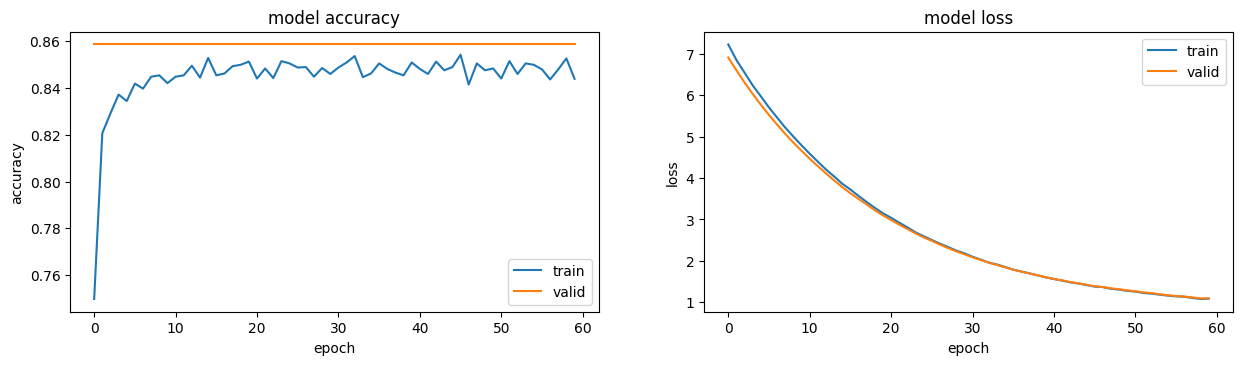

In [22]:
# plot accuracy and loss
plot_model_history(resnet50_base_model)


In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# plot confusion matrix
y_pred = np.round(resnet50_base_model.predict(x_test_reshaped))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d')


AttributeError: 'History' object has no attribute 'predict'